<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">

Custom Workloads
-------------------------

*Because not all problems are dataframes*

This notebook shows using [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to parallelize generic Python code.  

Dask.delayed is a simple and powerful way to parallelize existing code.  It allows users to delay function calls into a task graph with dependencies.  Dask.delayed doesn't provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed.  If you have a problem that is paralellizable, but isn't as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.

### Normal Python code

These aren't exciting functions, but hopefully you can see how your functions for your workflow might fit in here.

In [1]:
from time import sleep

def inc(x):
    from random import random
    sleep(random())
    return x + 1

def dec(x):
    from random import random
    sleep(random())
    return x - 1
    
def add(x, y):
    from random import random
    sleep(random())
    return x + y

### Run sequentially

In [38]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 350 µs, sys: 92 µs, total: 442 µs
Wall time: 382 µs


Delayed('add-55dbf044-d854-420f-84d5-4acc49b05a7d')

### Annotate Normal Python functions with Dask

These now become lazy versions.  Rather than compute the result immediately, they record what we want to compute and stick that task into a graph that we'll run later on parallel hardware.

In [39]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

Calling these lazy functions is now almost free.  We're just constructing a graph

In [40]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 424 µs, sys: 112 µs, total: 536 µs
Wall time: 422 µs


Delayed('add-e6bab91b-e2ef-4975-b377-03880ab097b2')

In [41]:
z

Delayed('add-e6bab91b-e2ef-4975-b377-03880ab097b2')

### Visualize computation

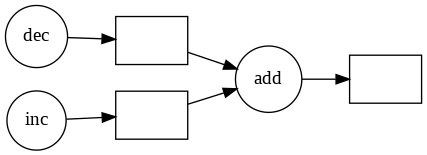

In [42]:
z.visualize(rankdir='LR')

### Execute with threads on our local machine

In [43]:
%%time
z.compute()

CPU times: user 4.78 ms, sys: 3.18 ms, total: 7.96 ms
Wall time: 1.78 s


3

### Connect to a cluster and run there

We connect to our cluster.  Now rather than run locally, all of our computations will happen on our cluster.

In [44]:
from dask.distributed import Client, progress
c = Client()
c

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1136: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| python  | 3.8.4.final.0 | 3.8.0.final.0 | 3.8.0.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://my-dask-scheduler:8786 Dashboard: http://my-dask-scheduler:8787/status,Cluster Workers: 3 Cores: 96 Memory: 253.20 GB


In [45]:
z.compute()

3

### Parallelize Normal Python code

Now we use Dask in normal for-loopy Python code.  This generates graphs instead of doing computations directly, but still looks like the code we had before.  Dask is a convenient way to add parallelism to existing workflows.

In [46]:
%%time
zs = []
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)
    
zs = dask.persist(*zs)
total = dask.delayed(sum)(zs)

Task was destroyed but it is pending!
task: <Task pending name='Task-582' coro=<DaskDistributedBackend._collect() running at /opt/conda/lib/python3.8/site-packages/joblib/_dask.py:198> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fe2483e8070>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /opt/conda/lib/python3.8/site-packages/tornado/ioloop.py:690]>


CPU times: user 45.5 ms, sys: 4.25 ms, total: 49.8 ms
Wall time: 48.2 ms


In [47]:
total.compute()

65536

By looking at the Dask dashboard we can see that Dask spreads this work around our cluster, managing load balancing, dependencies, etc..

### Custom computation: Tree summation

As an example of a non-trivial algorithm, consider the classic tree reduction.  We accomplish this with a nested for loop and a bit of normal Python logic.

```
finish           total             single output
    ^          /        \
    |        c1          c2        neighbors merge
    |       /  \        /  \
    |     b1    b2    b3    b4     neighbors merge
    ^    / \   / \   / \   / \
start   a1 a2 a3 a4 a5 a6 a7 a8    many inputs
```

In [48]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

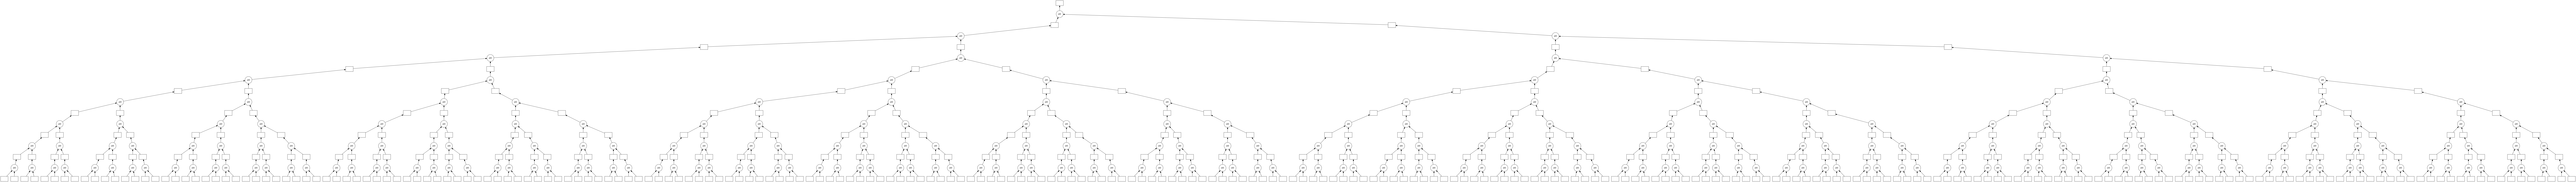

In [49]:
dask.visualize(*L)

In [50]:
dask.compute(L)

([65536],)

In [51]:
import pymc3 as pm
import joblib
from joblib import Parallel, delayed

In [52]:
def run_model(i=None):
    with pm.Model() as model:
        x = pm.Normal('x', mu = 1, sd =2)
        trace = pm.sample(chains = 1, cores = 1)
    return trace

<ipython-input-52-cbed0f5cf021>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(chains = 1, cores = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/opt/conda/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

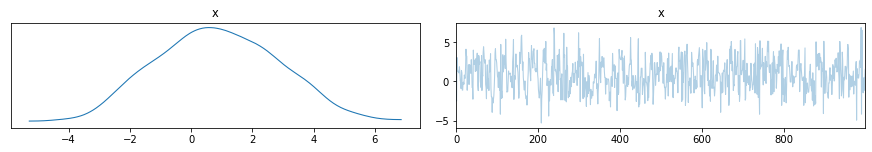

In [53]:
pm.plot_trace(run_model())

In [54]:
with joblib.parallel_backend('dask'):
    Parallel(n_jobs = 1, verbose=100)(delayed(run_model)() for i in range(1))

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 96 concurrent workers.


KilledWorker: ('batch_of_run_model_1_calls-42395be91267438d880ff7526c37dc1e', <Worker 'tcp://172.17.0.13:32965', name: tcp://172.17.0.13:32965, memory: 0, processing: 1>)

In [55]:
import time

def long_running_function(i):
    time.sleep(.1)
    return i

In [58]:
with joblib.parallel_backend('dask'):
    joblib.Parallel(verbose=100)(
        joblib.delayed(long_running_function)(i)
        for i in range(100))

Task was destroyed but it is pending!
task: <Task pending name='Task-967' coro=<DaskDistributedBackend._collect() running at /opt/conda/lib/python3.8/site-packages/joblib/_dask.py:198> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fe248d4ed60>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /opt/conda/lib/python3.8/site-packages/tornado/ioloop.py:690]>


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 96 concurrent workers.


KilledWorker: ('batch_of_long_running_function_1_calls-90fcfc23ae56455f8370a68c3c9a224b', <Worker 'tcp://172.17.0.14:36073', name: tcp://172.17.0.14:36073, memory: 0, processing: 55>)

Note the red bars for inter-worker communication.  Also note how there is lots of parallelism at the beginning but less towards the end as we reach the top of the tree where there is less work to do.